In [1]:
import jax
import jax.numpy as jnp
from NeuralPC.utils.dirac import DDOpt

In [2]:
# Create matrix rep of DDOpt
def get_matrix(Opt, dim):
    """
    Use standard basis to get matrix rep
    """
    vec_len = jnp.prod(jnp.array(dim))

    identiy = jnp.eye(vec_len)
    identiy += 1j*jnp.zeros_like(identiy)
    def apply_opt(vect, Opt):
        vect = vect.reshape(dim, order='C')
        out = Opt(vect)
        return out.reshape(-1, order='C')
    
    matrix = jax.vmap(apply_opt, in_axes=[0,None])(identiy, Opt)
    return matrix.T

def random_b(key, shape):
    # Generate random values for the real and imaginary parts
    real_part = 1 - jax.random.uniform(key, shape)
    imag_part = 1 - jax.random.uniform(jax.random.split(key)[1], shape)
    # Combine the real and imaginary parts
    complex_array = real_part + 1j * imag_part
    return complex_array


# experiment to understand the reshaping order
# i = jnp.eye(18) 
# i = i + 1j*jnp.zeros_like(i)
# print(i)
# a = i[5].reshape((1, 3, 3, 2), order='C')
# print(a.flatten())


In [7]:
from functools import partial
import os
from scipy.sparse.linalg import spilu
import scipy.sparse as sp
import numpy as np

jax.config.update("jax_enable_x64", True)


U1_org = jnp.load(
    "../../datasets/Dirac/precond_data/config.l8-N1600-b2.0-k0.276-unquenched.x.npy"
)
U1 = jnp.exp(1j * U1_org).astype(jnp.complex128)[:, jnp.newaxis, ...]  # (B, 2, X, T)

operator = partial(DDOpt, U1=U1[0:1, 0, ...], kappa=0.276)

mat = get_matrix(operator, (1, 8, 8, 2)).astype(U1.dtype)
x = random_b(jax.random.PRNGKey(0), (1, 8, 8, 2))
x = np.array(x)

mat_out = np.dot(mat, x.ravel())
opt_out = operator(x)

e = np.linalg.norm((mat_out - opt_out.ravel()))
print(e)




# ilu = spilu(mat)
# L = sp.csr_matrix(ilu.L)
# U = sp.csr_matrix(ilu.U)
# M_x = lambda x: ilu.solve(x)

# M_x_mat = L.dot(U).toarray()

# # test if matrix is valid

# x = random_b(jax.random.PRNGKey(0), (1, 8, 8, 2))
# x = np.array(x)


# y_true = M_x(x.flatten())
# y_pred = np.dot(M_x_mat, x.reshape(-1))

# error = y_true - y_pred

# print(jnp.linalg.norm(error))

# def data_gen_ilu(operator):
#     mat = get_matrix(operator, (1, 8, 8, 2)).astype(U1.dtype)
#     ilu = spilu(mat)
#     L = sp.csr_matrix(ilu.L)
#     U = sp.csr_matrix(ilu.U)
#     #M_x = lambda x: ilu.solve(x)
#     M_x_mat = L.dot(U).toarray() 
#     return M_x_mat

# data = {'U1':U1_org}
# M = []
# for i in range(U1.shape[0]):
#     operator = partial(DDOpt, U1=U1[i:i+1, 0, ...], kappa=0.276)
#     M_x_mat = data_gen_ilu(operator)
#     M.append(M_x_mat)

# M = np.stack(M, axis=0)
# data['M'] = M

# import pickle
# with open('../../datasets/Dirac/precond_data/ILU.pickle', 'wb') as f:
#     pickle.dump(data, f)




# check if linear operator aT(x) = T(ax) and T(x + ay) = T(x) + aT(y)


# a = 0.5
# x = 
# T_x = operator(x)
# aT_x = a * T_x
# T_ax = operator(a * x)

# e = aT_x - T_ax

# print(jnp.linalg.norm(e))

# T_x_ay = operator(x + a*x)
# Tx_aTy = operator(x) + a*operator(x)

# e2 = T_x_ay - Tx_aTy
# print(jnp.linalg.norm(e2))

3.018626708769446e-15


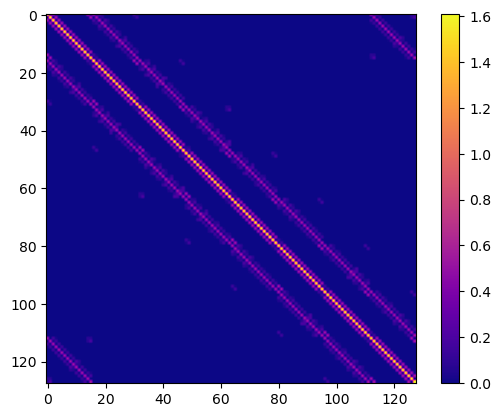

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im =  ax.imshow(jnp.abs(mat), cmap='plasma')
fig.colorbar(im)


In [88]:
def is_spd(matrix):
    """Check if a matrix is Symmetric Positive Definite (SPD)."""
    
    # Check for symmetry
    if not np.allclose(matrix, matrix.T):
        print('hi')
        return False

    # Check for positive definiteness
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False
    
is_spd(M_x_mat)

hi


False

In [91]:
# Test einsum
key = jax.random.PRNGKey(0)
A = jax.random.normal(key=key, shape=(100, 4, 4))
b = jax.random.normal(key=key, shape=(100, 4))

dotprod = jnp.dot(A[0], b[0])

eindot = jnp.einsum('bij, bj -> bi', A, b)

print(dotprod)
print(eindot[0])

[-0.50100583 -0.16442419  1.00329916 -1.11143384]
[-0.50100583 -0.16442419  1.00329916 -1.11143384]
